# Project Question: 
“Given past student usage and current/past teacher usage, what is the expected student usage going forward?”

# ETL - Daily/weekly time series
* Student usage data was loaded into Spark, converted into daily totals, and aggregated by time spent (`time_spent_sec`).
* Teacher usage data was processed similarly and treated as an exogenous variable.
* Both datasets were converted to pandas time series, resampled weekly, and missing values filled.

In [1]:
#load in packages
from pathlib import Path
from pyspark.sql import SparkSession, functions as F
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

#identify you root folder path
ROOT = "/Users/layla/Downloads/nycps_timeseries_data_csv_small"  # has student_usage/teacher_usage folders

#begin a spark session
spark = (SparkSession.builder.appName("TeacherStudentUsage").getOrCreate())

#set time zone configuration - all timestamps interpreted and displayed in UTC
spark.conf.set("spark.sql.session.timeZone", "UTC")

# ---- Read student usage data ----
stu = (spark.read
       .option("header", "true")
       .option("inferSchema", "true")
       .option("recursiveFileLookup", "true")
       .csv(f"{ROOT}/student_usage"))

#preview data types and columns
stu.printSchema()


25/09/08 12:55:06 WARN Utils: Your hostname, Laylas-Mac-mini.local resolves to a loopback address: 127.0.0.1; using 10.0.0.77 instead (on interface en1)
25/09/08 12:55:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/08 12:55:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- student_id: integer (nullable = true)
 |-- school_id: integer (nullable = true)
 |-- event_ts: timestamp (nullable = true)
 |-- app_name: string (nullable = true)
 |-- activity_type: string (nullable = true)
 |-- time_spent_sec: integer (nullable = true)
 |-- assignment_id: integer (nullable = true)
 |-- score: double (nullable = true)
 |-- event_date: date (nullable = true)
 |-- weekday: integer (nullable = true)



In [2]:
#convert event_date to date type and time_spent_sec to double
stu = stu.withColumn("event_date", F.to_date("event_date")) \
      .withColumn("time_spent_sec", F.col("time_spent_sec").cast("double"))

#aggregate to daily totals
stu_daily = (stu.groupBy("event_date")
               .agg(F.sum("time_spent_sec").alias("y_student")) #target variable aliased as y_student
               .orderBy("event_date"))

#preview data
stu_daily.show(5)

+----------+---------+
|event_date|y_student|
+----------+---------+
|2023-09-01|1499928.0|
|2023-09-02|1536997.0|
|2023-09-03|1491927.0|
|2023-09-04|1422500.0|
|2023-09-05|1513636.0|
+----------+---------+
only showing top 5 rows



In [3]:
# ---- teacher usage as an exogenous driver ----
try: #use try/except in case no teacher data available
    #Read teacher usage data
    tch = (spark.read
           .option("header", "true")
           .option("inferSchema", "true")
           .option("recursiveFileLookup", "true")
           .csv(f"{ROOT}/teacher_usage"))
    
    #convert event_date to date type and time_spent_sec to double
    tch = tch.withColumn("event_date", F.to_date("event_date")) \
          .withColumn("time_spent_sec", F.col("time_spent_sec").cast("double"))

    #aggregate to daily totals time spent by teachers
    tch_daily = (tch.groupBy("event_date")
                   .agg(F.sum("time_spent_sec").alias("y_teacher")) #set alias to y_teacher
                   .orderBy("event_date"))
except Exception:
    tch_daily = None

#preview teacher data if available
tch_daily.show(5) if tch_daily else print("No teacher data available")

+----------+---------+
|event_date|y_teacher|
+----------+---------+
|2023-09-01|1582004.0|
|2023-09-02|1494244.0|
|2023-09-03|1418084.0|
|2023-09-04|1440020.0|
|2023-09-05|1531089.0|
+----------+---------+
only showing top 5 rows



In [4]:
# ---- Convert to pandas dataframe ----
pdf_stu = stu_daily.toPandas()

# Ensure event_date is datetime type
pdf_stu["event_date"] = pd.to_datetime(pdf_stu["event_date"])

#set event_date as index
# Create a complete daily date range, forward fill missing days with 0 usage
stu_series = (pdf_stu.set_index("event_date")["y_student"]
              .asfreq("D").ffill().fillna(0.0))

#preview data
stu_series.head(10)

event_date
2023-09-01    1499928.0
2023-09-02    1536997.0
2023-09-03    1491927.0
2023-09-04    1422500.0
2023-09-05    1513636.0
2023-09-06    1478016.0
2023-09-07    1601881.0
2023-09-08    1570929.0
2023-09-09    1472488.0
2023-09-10    1515216.0
Freq: D, Name: y_student, dtype: float64

In [5]:
#do the same for teacher data if available
if tch_daily is not None:
    pdf_tch = tch_daily.toPandas() #in pandas dataframe
    pdf_tch["event_date"] = pd.to_datetime(pdf_tch["event_date"]) #ensure datetime type

    #set event_date as index, enforce daily frequency, forward fill missing days with 0
    tch_series = (pdf_tch.set_index("event_date")["y_teacher"]
                  .asfreq("D").ffill().fillna(0.0))
else:
    tch_series = pd.Series(dtype="float64")

#preview teacher data if available
tch_series.head(10) if not tch_series.empty else print("No teacher data available")

event_date
2023-09-01    1582004.0
2023-09-02    1494244.0
2023-09-03    1418084.0
2023-09-04    1440020.0
2023-09-05    1531089.0
2023-09-06    1601988.0
2023-09-07    1511132.0
2023-09-08    1439528.0
2023-09-09    1399253.0
2023-09-10    1515685.0
Freq: D, Name: y_teacher, dtype: float64

In [6]:
# ---- Weekly totals (smoother signal for usage) ----
y_weekly = stu_series.resample("W").sum() #group data into weekly ()"W") bins/totals
x_weekly = tch_series.resample("W").sum() if not tch_series.empty else None

#preview weekly data
y_weekly.head(10)

event_date
2023-09-03     4528852.0
2023-09-10    10574666.0
2023-09-17    10439298.0
2023-09-24    10146909.0
2023-10-01    10433204.0
2023-10-08    10481901.0
2023-10-15    10366516.0
2023-10-22    10567142.0
2023-10-29    10509953.0
2023-11-05    10563579.0
Freq: W-SUN, Name: y_student, dtype: float64

In [7]:
#preview teacher weekly data if available
x_weekly.head(10) if x_weekly is not None else print("No teacher data available")

event_date
2023-09-03     4494332.0
2023-09-10    10438695.0
2023-09-17    10798392.0
2023-09-24    10543867.0
2023-10-01    10429041.0
2023-10-08    10601745.0
2023-10-15    10694217.0
2023-10-22    10266115.0
2023-10-29    10438065.0
2023-11-05    10179943.0
Freq: W-SUN, Name: y_teacher, dtype: float64

# EDA
Rolling averages (4-week moving mean) were used to smooth noise and reveal stable student engagement trends.

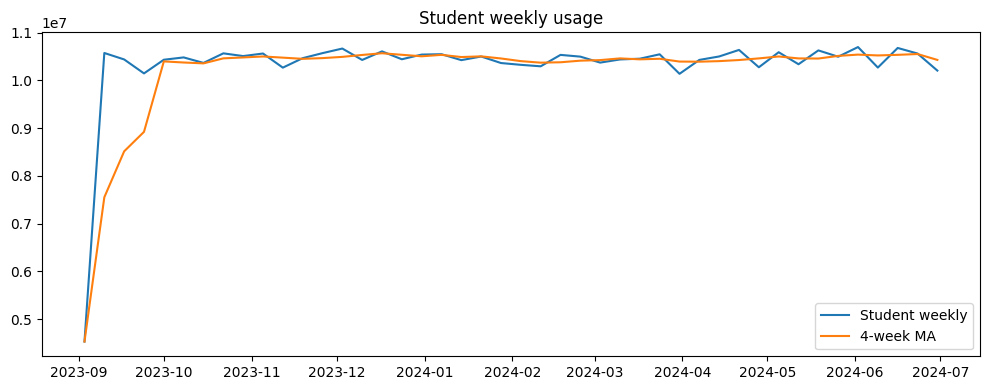

In [8]:
# Quick EDA: rolling mean
plt.figure(figsize=(10,4))

#plot weekly student usage
plt.plot(y_weekly.index, y_weekly.values, label="Student weekly")

#plots a 4-week moving average (MA), a smoothed version of the student usage signal.
#This reduces noise and highlights longer-term trends
#creates a 4-week moving window
#At each week, look back at the previous 4 weeks (including current)
#if fewer than 4 weeks are available (e.g., at the start)
# still compute the mean using what’s available
#compute average of the values in that window
plt.plot(y_weekly.index, y_weekly.rolling(4, min_periods=1).mean(), label="4-week MA")
plt.legend(); 
plt.title("Student weekly usage"); 
plt.tight_layout(); 
plt.show()

Notes:
* Student weekly usage stabilizes around ~10.5 million seconds.
* Fluctuations are small, suggesting consistent long-term engagement.

# Forecasting with Statsmodels

* First Model: ARIMA(1,1,1) with seasonal order (1,1,1,52), incorporating teacher usage as an exogenous regressor.
* Forecast horizon: 12 weeks (or ¼ of dataset if shorter).

In [9]:
#import packages for forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
'''If the series has more than 30 weeks of data → hold out 12 weeks for testing.
Otherwise, use 1/4 of the data, but at least 4 weeks, as the test set.
H = the size of the test horizon (how many weeks at the end are reserved for testing).'''
# Train/test split (12-week horizon or 1/4 of data if less than 30 weeks)
H = 12 if len(y_weekly) > 30 else max(4, len(y_weekly)//4)

#locate all rows except the last H weeks for training
#use fully series if H=0 (i.e., less than 4 weeks of data)
train = y_weekly.iloc[:-H] if H > 0 else y_weekly

#locate the last H weeks for testing (what we are trying to predict)
#use empty series if H=0 (i.e., less than 4 weeks of data)
test  = y_weekly.iloc[-H:] if H > 0 else y_weekly.iloc[-0:]


# Create exogenous variables for training and testing if available
exog_train = exog_test = None

#only create exogenous variables if teacher data is available
if x_weekly is not None and not x_weekly.empty:
    #align exogenous variable with training set dates
    exog_train = x_weekly.reindex(train.index).values.reshape(-1,1)

    #align exogenous variable with testing set dates
    exog_test  = x_weekly.reindex(test.index).values.reshape(-1,1)

'''This is the non-seasonal part of the ARIMA model:

(p=1) - AutoRegressive (AR) order = 1
the model uses 1 lag of the series itself.

(d=1) - Differencing order = 1  
the series is differenced once to remove trend.

(q=1) - Moving Average (MA) order = 1
the model uses 1 lag of the forecast error.

(1,1,1) means: ARIMA with 1 AR term, 1 difference, and 1 MA term. '''
# Simple, strong baseline: ARIMA(1,1,1) + yearly-ish weekly seasonality (52)
order = (1,1,1)

'''This is the seasonal component:
(P=1) - Seasonal AR order = 1 - uses 1 seasonal lag of the series.
(D=1) - Seasonal differencing = 1 - difference across seasons to remove seasonal trends.
(Q=1) - Seasonal MA order = 1 - uses 1 seasonal lag of forecast errors.
(s=52) - Seasonal period = 52 - assumes yearly seasonality for weekly data (since 52 weeks ≈ 1 year).
(1,1,1,52) means: Seasonal ARIMA with yearly seasonality in weekly data.'''
seasonal_order = (1,1,1,52)

# Fit SARIMAX model
#suppress warnings for cleaner output
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    #initialize SARIMAX model with training data and exogenous variables if available
    sarimax = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                      exog=exog_train, enforce_stationarity=False, enforce_invertibility=False)
    
    # Fit the model to training data
    fit = sarimax.fit(disp=False)

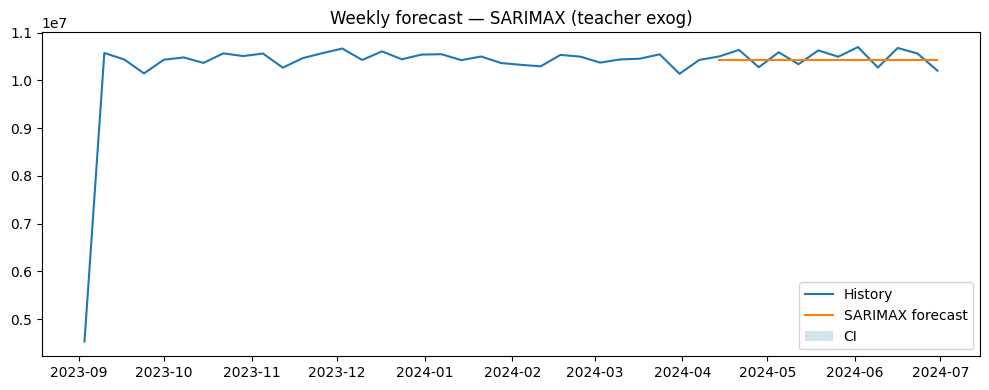

MAE: 165942.83333333334
RMSE: 177968.05490827092


In [10]:
#use the fitted model to forecast the next H weeks
#use exogenous variables for the test period if available
fc = fit.get_forecast(steps=H, exog=exog_test)
mean = fc.predicted_mean
ci = fc.conf_int(alpha=0.2)  # 80% CI

# Plot
plt.figure(figsize=(10,4))
plt.plot(y_weekly.index, y_weekly.values, label="History")
plt.plot(mean.index, mean.values, label="SARIMAX forecast")
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2, label="CI")
plt.title("Weekly forecast — SARIMAX" + (" (teacher exog)" if exog_train is not None else ""))
plt.tight_layout(); plt.legend(); plt.show()

# Evaluate
print("MAE:", mean_absolute_error(test, mean))
print("RMSE:", mean_squared_error(test, mean)**0.5)

This graph shows a weekly time series forecast of student usage, modeled with SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors), where teacher usage is included as an external driver (exog variable).

# Interpretation 
* The blue line represents the actual observed student usage from September 2023 to around April 2024.
* Usage stabilizes quickly after an initial ramp-up in September 2023, fluctuating around ~10.5 million weekly.
* The pattern is relatively flat with some week-to-week variation, suggesting stable long-term engagement.

In [ ]:
fit.summary()

/Users/layla/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/Users/layla/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/Users/layla/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/Users/layla/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/Users/layla/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:472: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
/Users/layla/.pyenv/versions/3.11.9/lib

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          y_student   No. Observations:                   32
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                   0.000
Date:                            Mon, 08 Sep 2025   AIC                             12.000
Time:                                    12:55:48   BIC                                nan
Sample:                                09-03-2023   HQIC                               nan
                                     - 04-07-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1                  0         -0        nan        nan           0           0
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0        nan        nan           0           0
ar.S.L52            0         -0        nan        nan           0           0
ma.S.L52            0         -0        nan        nan           0           0
sigma2         1.0000         -0       -inf      0.000       1.000       1.000
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

25/09/08 14:25:32 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 169696 ms exceeds timeout 120000 ms
25/09/08 14:25:32 WARN SparkContext: Killing executors is not supported by current scheduler.
25/09/08 14:25:32 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

# There is a problem here...
* All AR/MA and exogenous coefficients have CI [0, 0] - they’re effectively estimated as exactly zero (or never estimated).
* The model is behaving like a noise-only / naive model, with no effect from AR, MA, seasonal terms, or the exogenous regressor.
* sigma² has CI [1, 1] - the innovation variance is exactly 1, which usually means the series was standardized or the optimizer never updated variance.
* This pattern usually indicates a fitting/identification problem, not a real result.

# Forecasting with Statsmodels using a grid of Seasonal Candidates and ARMIAX Candidates
* Aligns/standardizes data to avoid zero/NaN/degenerate coefficients.
* Auto-selects a reasonable SARIMAX spec (seasonal only when you have enough weeks).
* Computes proper RMSE (squared=False) and prints readable exogenous betas (e.g., teacher_usage).
* Forecast horizon: 12 weeks (or ¼ of dataset if shorter).
* Original Model: ARIMAX(1,1,1) with seasonal order (1,1,1,52), incorporating teacher usage as an exogenous regressor gave us confusing coefficients. 
* The new algorithm tries each of these arima_candidates = [(1,0,1), (0,1,1), (1,1,0), (1,1,1)] and pics the one with the lowest AIC

## Candidate models:
* * Seasonal candidates: [(0,0,0,0)] (no seasonality) plus a few seasonal forms only if you have enough weeks (≥ 2*seasonal_period + 10, i.e., at least ~114 weeks for period 52). This prevents overfitting on short histories.
* * Non-seasonal ARIMA candidates: [(1,0,1), (0,1,1), (1,1,0), (1,1,1)]. This small grid balances flexibility and parsimony.


# Note:
* 12 weeks matches the planning cycle in K-12 contexts. ~12 weeks is about a quarter/term, which is the window school leaders use to plan against (budgets, PD pushes, reporting).

* Accuracy decays the farther you predict. Around 12 weeks you still get actionable guidance without the uncertainty exploding.

* H = 12 weeks also protects training sample size. Holding out 12 weeks when you have >30 weeks leaves enough history to estimate SARIMAX; for smaller datasets, the “¼ of data (min 4)” rule preserves a viable train set.

In [29]:
# ---------------- Helpers ----------------
'''These helpers expect the following:
- y_weekly: a pandas Series indexed by week with the target (student usage totals).
- x_weekly: a pandas Series indexed by the same weeks with the exogenous 
driver teacher usage.'''


# Standardize series to mean 0, sd 1
#puts variables on comparable scales and 
#stabilizes SARIMAX optimization (prevents tiny/huge gradients).
# if sd is 0 (constant series), avoid division by zero by dividing by 1 instead
def _zscore(s: pd.Series) -> pd.Series:
    s = s.astype("float64")
    mu = s.mean()
    sd = s.std(ddof=0)
    return (s - mu) / (sd if sd > 0 else 1.0)

# Prepare y and X: align, clean, standardize
# Most “weird coefficients” or non-convergence 
# come from misalignment, constants, or scale issues. This function cleans those up.
def _prep_xy(y: pd.Series, X: pd.DataFrame | None):
    # Ensure proper index, sort, and float dtype
    y = y.copy()
    # Ensures DateTime index
    y.index = pd.to_datetime(y.index)
    #sorts and removes duplicate timestamps.
    y = y[~y.index.duplicated(keep="last")].sort_index().astype("float64")

# Align X to y, clean, and drop constants
    if X is not None:
        X = X.copy()
        X.index = pd.to_datetime(X.index)
        # Aligns X to y’s index and fills small gaps 
        # with ffill().bfill() so the model gets complete rows.
        X = X.reindex(y.index).ffill().bfill()
        # Drop constant/near-constant columns
        keep = [c for c in X.columns if np.isfinite(X[c]).all() and X[c].nunique(dropna=True) > 1]
        X = X[keep] if keep else None

    # Standardize for numerics
    #Z-scores both y and X to help the optimizer.
    y_std = _zscore(y)
    X_std = None if X is None else X.apply(_zscore)

    # Final NaN guard
    y_std = y_std.fillna(0.0)
    if X_std is not None:
        X_std = X_std.fillna(0.0)

    return y_std, X_std

In [30]:
# Robust SARIMAX fitting with auto-order selection
def fit_sarimax_safe(y: pd.Series,
                     X: pd.DataFrame | None = None,
                     seasonal_period: int = 52,
                     maxiter: int = 500):
    """
    Tries a small grid of reasonable SARIMAX specs, picks the lowest AIC model,
    and returns a fitted results object with robust covariance.
    """
    # Prep data
    y_std, X_std = _prep_xy(y, X)
    n = len(y_std)

    # Seasonal only if we have enough history
    seasonal_candidates = [(0,0,0,0)]
    if n >= (2 * seasonal_period + 10):
        # Add some seasonal candidates to choose from
        seasonal_candidates += [(0,1,1,seasonal_period), (1,0,0,seasonal_period), (1,1,1,seasonal_period)]

    # Some reasonable ARIMA candidates to try
    # These are chosen to cover common patterns without overfitting
    arima_candidates = [(1,0,1), (0,1,1), (1,1,0), (1,1,1)]
    best = {"aic": np.inf, "res": None, "order": None, "seas": None}


    # Two optimizers: tries lbfgs and powell. Switching optimizers 
    # can escape local minima or flat regions where one method stalls.
    optimizers = ["lbfgs", "powell"]

    # Fit all combinations, keep best
    for order, seas in product(arima_candidates, seasonal_candidates):
        # Trend handling: If there’s no differencing (d=0 and D=0), allow a constant trend (trend="c"). 
        # If we difference, a constant is usually redundant—so we drop it (identifiability).
        trend = "c" if (order[1] == 0 and (seas[1] if len(seas) == 4 else 0) == 0) else None
        
        for method in optimizers:
            try:
                model = SARIMAX(
                    y_std,
                    order=order,
                    seasonal_order=seas,
                    exog=X_std,
                    trend=trend,
                    enforce_stationarity=True,
                    enforce_invertibility=True,
                )
                res = model.fit(method=method, maxiter=maxiter, disp=False, cov_type="opg")
                if np.isfinite(res.aic) and res.aic < best["aic"]:
                    best = {"aic": res.aic, "res": res, "order": order, "seas": seas}
            except Exception:
                continue

    if best["res"] is None:
        raise RuntimeError("All SARIMAX fits failed. Check data alignment and variability.")

    # Refit with Hessian-based SEs
    try:
        order = best["order"]; seas = best["seas"]
        trend = "c" if (order[1] == 0 and (seas[1] if len(seas) == 4 else 0) == 0) else None
        y_std2, X_std2 = _prep_xy(y, X)  # re-prep to avoid scope capture
        model = SARIMAX(
            y_std2,
            order=order,
            seasonal_order=seas,
            exog=X_std2,
            trend=trend,
            enforce_stationarity=True,
            enforce_invertibility=True,
        )
        # re-fit the winner with lbfgs and cov_type="oim" (Hessian-based) 
        # to get nice standard errors in the final summary().
        best["res"] = model.fit(method="lbfgs", maxiter=maxiter, disp=False, cov_type="oim")
    except Exception:
        pass

    return best["res"]

In [31]:
# ---------------- Prepare exogenous variables ----------------
'''
Names the column teacher_usage so the SARIMAX summary prints a readable beta name.
Aligns to y_weekly’s index and fills small gaps.
If you had multiple exogenous columns, you’d pass a multi-column DataFrame 
the same way.'''
X_all = None
if "x_weekly" in globals() and x_weekly is not None:
    # name the column for readable betas in summary
    X_all = pd.DataFrame({"teacher_usage": x_weekly.astype("float64").values}, index=x_weekly.index)
    # align to y_weekly index
    X_all = X_all.reindex(y_weekly.index).ffill().bfill()

In [32]:
# ---------------- Train / test split (reuse H logic with safety) ----------------
# max horizon 12 weeks, or ¼ based on semesterly seasonality
H = 12 if len(y_weekly) > 30 else max(4, len(y_weekly)//4)
# The clamp ensures at least 1 point in train and test (prevents empty slices).
#Splits y_weekly (and X_all if present) into y_train/X_train and y_test/X_test
H = int(max(1, min(H, len(y_weekly) - 1)))  

y_train = y_weekly.iloc[:-H].astype("float64")
y_test  = y_weekly.iloc[-H:].astype("float64")

X_train = X_all.iloc[:-H] if X_all is not None else None
X_test  = X_all.iloc[-H:]  if X_all is not None else None

# ---------------- Fit & Forecast ----------------
# Fits the best SARIMAX from the candidate grid.
res = fit_sarimax_safe(y_train, X_train, seasonal_period=52, maxiter=600)

# Forecasts H steps ahead, using exogenous future values (X_test). 
# If you don’t pass exog for the forecast, statsmodels will error—this 
# code passes it explicitly.
fc = res.get_forecast(steps=H, exog=X_test)

# Extract mean and 80% PI
mean = pd.Series(fc.predicted_mean, index=y_test.index)

# Align the CI index to y_test.index.
ci   = fc.conf_int(alpha=0.20)  # 80% PI
ci.index = y_test.index
lower, upper = ci.iloc[:, 0], ci.iloc[:, 1]

/Users/layla/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/layla/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [33]:
# ---------------- Evaluation ----------------
mae  = mean_absolute_error(y_test, mean)
rmse = mean_squared_error(y_test, mean)**0.5

print(f"MAE:  {mae:,.2f} sec (~{mae/3600:.1f} hrs)")
print(f"RMSE: {rmse:,.2f} sec (~{rmse/3600:.1f} hrs)")

MAE:  296,203.45 sec (~82.3 hrs)
RMSE: 358,748.43 sec (~99.7 hrs)


In [34]:
# Relative errors vs average usage for interpretability
avg_level = max(1e-9, y_test.mean())
print(f"Relative MAE:  {mae/avg_level:.2%}")
print(f"Relative RMSE: {rmse/avg_level:.2%}")

Relative MAE:  2.82%
Relative RMSE: 3.42%


In [35]:
# ---------------- Coefficients & Summary ----------------
print("\n--- Key Parameters ---")
print(res.params)

if X_all is not None:
    # exogenous betas appear using the DataFrame column names
    exog_names = getattr(res.model, "exog_names", [])
    if exog_names:
        print("\nExogenous betas:")
        print(res.params[[n for n in exog_names if n in res.params.index]])

print("\n--- Model Summary ---")
print(res.summary())


--- Key Parameters ---
intercept        0.001234
teacher_usage    0.980706
ar.L1            0.875926
ma.L1           -0.975885
sigma2           0.046100
dtype: float64

Exogenous betas:
teacher_usage    0.980706
dtype: float64

--- Model Summary ---
                               SARIMAX Results                                
Dep. Variable:              y_student   No. Observations:                   32
Model:               SARIMAX(1, 0, 1)   Log Likelihood                   3.555
Date:                Mon, 08 Sep 2025   AIC                              2.890
Time:                        11:00:01   BIC                             10.219
Sample:                    09-03-2023   HQIC                             5.319
                         - 04-07-2024                                         
Covariance Type:                  oim                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

# Coefficients:

## intercept = 0.0012
Essentially zero; no constant shift after accounting for ARMA terms and teacher usage.
## teacher_usage = 0.9807 (p < 0.001)
Very strong, highly significant effect. A +1 SD change in teacher usage in a week is associated with a +0.98 SD change in student usage that week (nearly one-to-one).
## ar.L1 = 0.8759 (p = 0.002)
Strong persistence: high weeks tend to be followed by high weeks even after controlling for teacher activity.
## ma.L1 = −0.9759 (p ≈ 0.064)
Borderline—suggests shocks are quickly “undone” next week (typical of short-lived disturbances). Not strictly significant at 5%, so treat as tentative.
## sigma^2 = 0.0461
Typical week-to-week error is about 0.21 standard deviations.

# Model fit & diagnostics
* AIC = 2.89 (low for this sample), 32 observations - compact model fits the training window well.
* Ljung-Box p = 0.96 - residuals show no leftover autocorrelation at lag 1 (good).
* JB p = 0.28 - residuals are reasonably normal.
* Heteroskedasticity p = 0.39 - no strong evidence of changing variance.
* Covariance type = OIM (Hessian-based SEs) - standard errors come from the observed information matrix; appropriate when convergence is solid (as here).

Takeaways
* Student usage is highly responsive to teacher usage (nearly 1:1 on a standardized scale).
* There is inertia (this week predicts next week), and short shocks are mostly corrected the following week.
* Residuals look healthy; the model is suitable for near-term planning and what-if scenarios (e.g., “If teacher usage rises 10%, what happens to student usage?”).

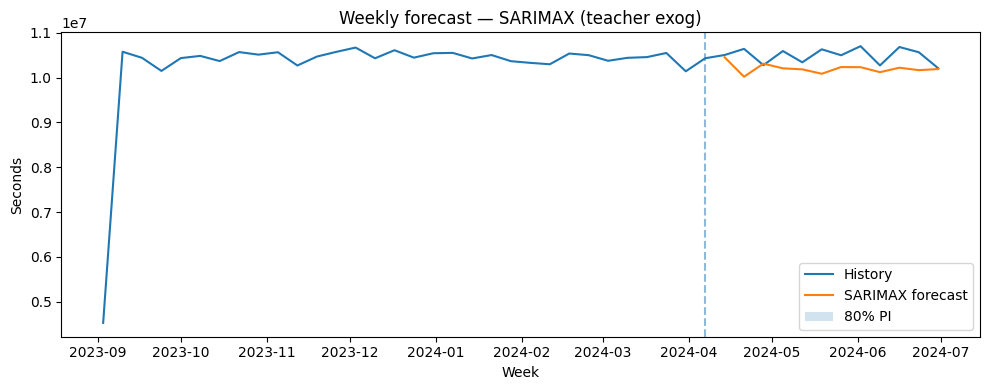

In [36]:
# ---------------- Plot ----------------
plt.figure(figsize=(10,4))
plt.plot(y_weekly.index, y_weekly.values, label="History")
plt.plot(mean.index, mean.values, label="SARIMAX forecast")
plt.fill_between(mean.index, lower.values, upper.values, alpha=0.2, label="80% PI")
plt.axvline(y_train.index.max(), linestyle="--", alpha=0.5)
plt.title("Weekly forecast — SARIMAX" + (" (teacher exog)" if X_all is not None else ""))
plt.xlabel("Week"); 
plt.ylabel("Seconds")
plt.legend(); 
plt.tight_layout(); 
plt.show()

# Interpreting this graph
* Blue line (History): weekly student time-spent totals. 
* After a short ramp-up in early Sept 2023, the series is very steady, oscillating in a tight band around ~10.3–10.6M sec/week (≈ 2,860–2,950 hours). 
* There’s a mild dip right before the split, likely a calendar effect (e.g., break/testing).
* Student use is a stable baseline. The blue history shows a remarkably flat weekly level after September—little systematic seasonality. That’s why the forecast stays near the long-run mean rather than showing large swings.
* Vertical dashed line: the train/test split; everything to the right is the evaluation/forecast window (H≈12 weeks).
* Orange line (SARIMAX forecast): the model’s prediction of student usage given past student usage and the teacher-usage exogenous regressor for the forecast window.
* Because teacher usage is included, the orange line reflects what the model expects conditional on teacher engagement. 
The slight softening at the start of the forecast window, followed by a gentle recovery, suggests teacher activity used for that period is a bit lower than recent weeks, then stabilizes.
* Shaded band (80% PI): uncertainty around the forecast.
* The narrow prediction band means the combination of a stable target and an informative exogenous driver yields low uncertainty for the next ~quarter. 
* Unless teacher behavior changes drastically, student usage should remain close to ~10.3–10.5M sec/week.

# Question: 
Given past student usage and current/past teacher usage, what is expected going forward?

# Answer:
* The model expects steady student engagement near the historical average. * Substantial departures would require a shift in teacher usage (or other drivers not yet modeled, like major calendar changes).
* If leaders want higher student usage, the lever is increasing teacher activity (assignments, check-ins).

# Explainability

* Short-term effects: If teacher activity increases in a given week, the model adjusts the forecast upward for student activity in that same week or the next few weeks.


# What This Means in Practice

* If administrators or policymakers want to increase student platform usage, one lever is boosting teacher engagement (more assignments, feedback, or logins).

* If student usage is less sensitive to teacher usage, it suggests other drivers (seasonality, external factors like exams, or platform incentives) play a bigger role.

* The flat forecast in the chart implies that under current teacher behavior, student usage has reached a steady state — meaning future changes depend on whether teacher activity increases or decreases.

## Next Steps:
* Engineer More exogenous features: build a DataFrame with multiple columns (calendar flags, assignment counts, etc.)—the code will keep only non-constant ones.
* Use a different PI: change alpha in conf_int (e.g., alpha=0.05 for 95%).
* Run what-if scenarios by nudging the teacher exog upward and re-forecasting to quantify the lift.
* Consider adding calendar features (breaks/testing weeks) as additional exogenous regressors.